In [47]:
# importing libraries
from datetime import datetime,timedelta,date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from __future__ import division

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold,cross_val_score,train_test_split,GridSearchCV,KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
# load data

cus_df = pd.read_csv('online_retail_II.csv')

cus_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
cus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [4]:
cus_df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
# converting invoicedate into datetime object

cus_df['InvoiceDate'] = pd.to_datetime(cus_df['InvoiceDate'])

cus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
# dropping missing values

cus_df.dropna(inplace= True)

cus_df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
pd.DataFrame(cus_df['InvoiceDate'].describe())

C:\Users\user\AppData\Local\Temp\ipykernel_8924\4224229776.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.DataFrame(cus_df['InvoiceDate'].describe())


,InvoiceDate
count,824364
unique,41439
top,2011-11-14 15:27:00
freq,543
first,2009-12-01 07:45:00
last,2011-12-09 12:50:00


In [8]:
# creating 1year 2month and 6month dataframe for historical data and future data respectively

cus_1y_2m = cus_df[(cus_df['InvoiceDate'] >= pd.Timestamp(2010,3,1)) & (cus_df['InvoiceDate'] < pd.Timestamp(2011,6,1))].reset_index(drop=True)
cus_6m = cus_df[(cus_df['InvoiceDate'] >= pd.Timestamp(2011,6,1)) & (cus_df['InvoiceDate']<pd.Timestamp(2011,12,1))].reset_index(drop=True)

In [9]:
# ned df for assigning clusterring

cus_ctr = pd.DataFrame(cus_df['Customer ID'].unique())
cus_ctr.columns = ['Customer ID']
cus_ctr.head()

,Customer ID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


In [10]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [11]:
# recency score

recency_df = pd.DataFrame(cus_1y_2m.groupby('Customer ID')['InvoiceDate'].max().reset_index())
recency_df.columns = ['Customer ID','LastPurchaseDate']
recency_df['Recency'] = (recency_df['LastPurchaseDate'].max()-recency_df['LastPurchaseDate']).dt.days

In [12]:
recency_df

,Customer ID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,133
1,12347.0,2011-04-07 10:43:00,54
2,12348.0,2011-04-05 10:47:00,56
3,12349.0,2010-10-28 08:23:00,215
4,12350.0,2011-02-02 16:01:00,117
...,...,...,...
4729,18281.0,2010-05-11 10:49:00,385
4730,18283.0,2011-05-23 11:33:00,8
4731,18284.0,2010-10-06 12:31:00,237
4732,18286.0,2010-08-20 11:57:00,284


In [13]:
cus_ctr = pd.merge(cus_ctr,recency_df[['Customer ID','Recency']],on='Customer ID')

In [14]:
cus_ctr.head()

,Customer ID,Recency
0,13085.0,32
1,13078.0,6
2,15362.0,256
3,18102.0,14
4,12682.0,0


In [15]:
# form clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(cus_ctr[['Recency']])
cus_ctr['RecencyCluster'] = kmeans.predict(cus_ctr[['Recency']])

cus_ctr.head()

,Customer ID,Recency,RecencyCluster
0,13085.0,32,3
1,13078.0,6,3
2,15362.0,256,0
3,18102.0,14,3
4,12682.0,0,3


In [16]:
# oder recency cluster

cus_ctr = order_cluster('RecencyCluster','Recency',cus_ctr,False)

cus_ctr.head()

,Customer ID,Recency,RecencyCluster
0,13085.0,32,3
1,13078.0,6,3
2,18102.0,14,3
3,12682.0,0,3
4,14110.0,28,3


In [17]:
cus_ctr.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,667.0,372.796102,46.050734,294.0,334.0,372.0,411.0,456.0
1,1578.0,214.300380,33.315250,159.0,188.0,208.0,237.0,293.0
2,937.0,95.407684,25.278624,60.0,72.0,91.0,118.0,147.0
3,1552.0,23.391108,16.568355,0.0,9.0,20.0,39.0,58.0


In [18]:
# Freqeuncy

frequency_df = cus_1y_2m.groupby('Customer ID')['InvoiceDate'].count().reset_index()
frequency_df.columns = ['Customer ID','Frequency']
cus_ctr = pd.merge(cus_ctr,frequency_df,on='Customer ID')
cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency
0,13085.0,32,3,21
1,13078.0,6,3,547
2,18102.0,14,3,515
3,12682.0,0,3,606
4,14110.0,28,3,273


In [19]:
# frequency cluster
kmeans.fit(cus_ctr[['Frequency']])
cus_ctr['FrequencyCluster'] = kmeans.predict(cus_ctr[['Frequency']])
cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,32,3,21,0
1,13078.0,6,3,547,2
2,18102.0,14,3,515,2
3,12682.0,0,3,606,2
4,14110.0,28,3,273,2


In [20]:
# order frequency cluster
cus_ctr = order_cluster('FrequencyCluster','Frequency',cus_ctr,True)


cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,32,3,21,0
1,17519.0,14,3,150,0
2,13758.0,9,3,188,0
3,12362.0,33,3,58,0
4,16011.0,40,3,247,0


In [21]:
cus_ctr.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4298.0,59.613309,58.196743,1.0,17.0,39.0,83.0,252.0
1,420.0,445.923810,199.991811,253.0,306.0,374.5,525.5,1290.0
2,13.0,2173.846154,566.948682,1487.0,1752.0,2177.0,2305.0,3611.0
3,3.0,5572.000000,1209.209659,4194.0,5130.0,6066.0,6261.0,6456.0


In [22]:
# Revenue
cus_1y_2m['Revenue'] = cus_1y_2m['Quantity'] * cus_1y_2m['Price']

# total revenue
revenue_df = cus_1y_2m.groupby('Customer ID')['Revenue'].sum().reset_index()
revenue_df.columns = ['Customer ID','TotalRevenue']
cus_ctr = pd.merge(cus_ctr,revenue_df,on='Customer ID')

#average revenue
revenue_mean = cus_1y_2m.groupby('Customer ID')['Revenue'].mean().reset_index()
revenue_mean.columns = ['Customer ID','MeanRevenue']
cus_ctr = pd.merge(cus_ctr,revenue_mean,on='Customer ID')
cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue
0,13085.0,32,3,21,0,-695.72,-33.129524
1,17519.0,14,3,150,0,3313.94,22.092933
2,13758.0,9,3,188,0,5442.71,28.950585
3,12362.0,33,3,58,0,969.44,16.714483
4,16011.0,40,3,247,0,2951.86,11.950850


In [23]:
# cluster
kmeans.fit(cus_ctr[['TotalRevenue']])
cus_ctr['TotalRevenueCluster'] = kmeans.predict(cus_ctr[['TotalRevenue']])
cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster
0,13085.0,32,3,21,0,-695.72,-33.129524,0
1,17519.0,14,3,150,0,3313.94,22.092933,0
2,13758.0,9,3,188,0,5442.71,28.950585,0
3,12362.0,33,3,58,0,969.44,16.714483,0
4,16011.0,40,3,247,0,2951.86,11.950850,0


In [24]:
# order revenue ccluster

cus_ctr = order_cluster('TotalRevenueCluster','TotalRevenue',cus_ctr,True)

cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster
0,13085.0,32,3,21,0,-695.72,-33.129524,0
1,17519.0,14,3,150,0,3313.94,22.092933,0
2,13758.0,9,3,188,0,5442.71,28.950585,0
3,12362.0,33,3,58,0,969.44,16.714483,0
4,16011.0,40,3,247,0,2951.86,11.950850,0


In [25]:
cus_ctr.groupby('TotalRevenueCluster')['TotalRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
TotalRevenueCluster,,,,,,,,
0,4624.0,1318.672240,1840.497717,-25111.09,293.7875,665.47,1640.225,10995.48
1,97.0,20866.664227,10966.303152,11096.95,13268.2000,16781.37,24143.440,56560.58
2,11.0,96617.818182,31524.374362,61254.83,71301.9200,93417.58,105378.185,154933.50
3,2.0,299834.630000,6488.496677,295246.57,297540.6000,299834.63,302128.660,304422.69


In [26]:
# overall score and segmenting customers

cus_ctr['Overall_Score'] = (cus_ctr['RecencyCluster']+cus_ctr['FrequencyCluster']+cus_ctr['TotalRevenueCluster'])
cus_ctr['Segment'] = 'Low-Value'
cus_ctr.loc[cus_ctr['Overall_Score']>2,'Segment'] = 'Mid-Value' 
cus_ctr.loc[cus_ctr['Overall_Score']>4,'Segment'] = 'High-Value'

In [27]:
cus_ctr

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster,Overall_Score,Segment
0,13085.0,32,3,21,0,-695.72,-33.129524,0,3,Mid-Value
1,17519.0,14,3,150,0,3313.94,22.092933,0,3,Mid-Value
2,13758.0,9,3,188,0,5442.71,28.950585,0,3,Mid-Value
3,12362.0,33,3,58,0,969.44,16.714483,0,3,Mid-Value
4,16011.0,40,3,247,0,2951.86,11.950850,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...,...
4729,13089.0,5,3,2200,2,72769.80,33.077182,2,7,High-Value
4730,14298.0,27,3,1885,2,61254.83,32.495931,2,7,High-Value
4731,14911.0,5,3,6456,3,147601.59,22.862700,2,8,High-Value
4732,18102.0,14,3,515,1,304422.69,591.112019,3,7,High-Value


## Creating Target ltv variable
There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.

In [28]:
cus_6m['Revenue'] = cus_6m['Quantity'] * cus_6m['Price']
cus_user_6m = cus_6m.groupby('Customer ID')['Revenue'].sum().reset_index()
cus_user_6m.columns = ['Customer ID','m6_Revenue']

In [29]:
cus_user_6m.head()

,Customer ID,m6_Revenue
0,12347.0,2261.75
1,12348.0,310.00
2,12349.0,1757.55
3,12352.0,944.23
4,12356.0,58.35


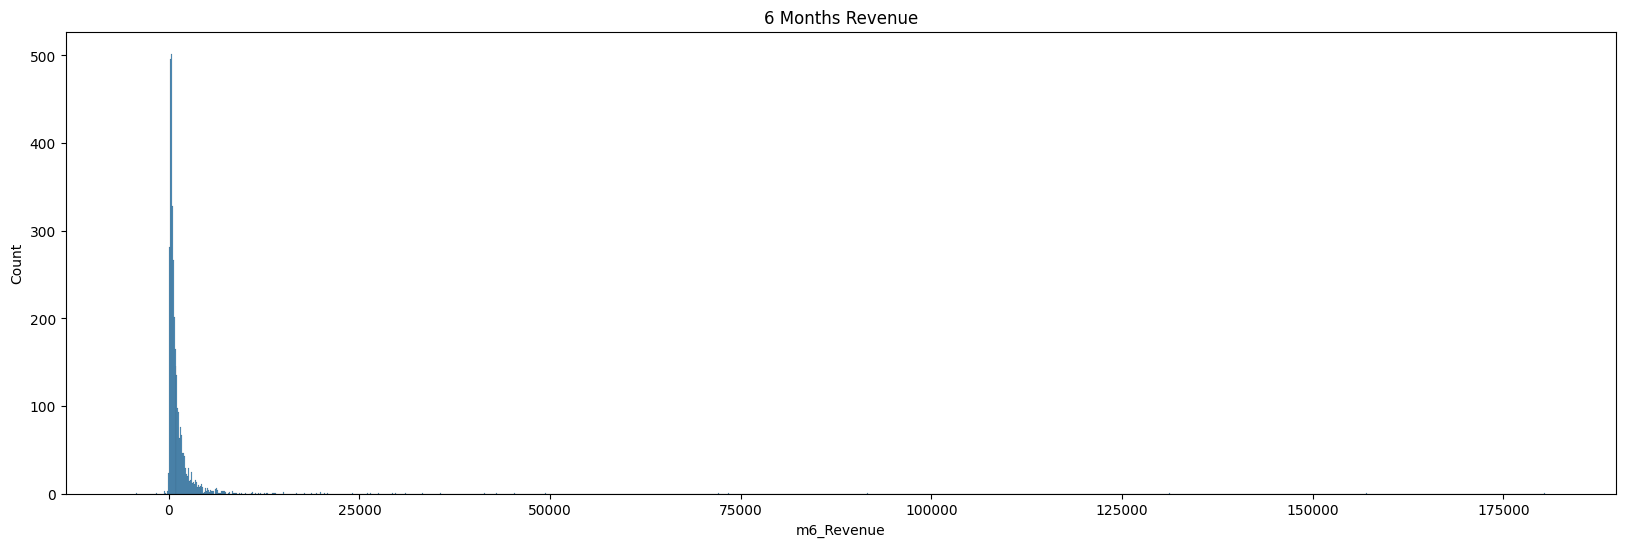

In [30]:
plt.figure(figsize=(20,6))
sns.histplot(data=cus_user_6m,x=cus_user_6m['m6_Revenue'])
plt.title('6 Months Revenue');

Histogram clearly shows we have customers with negative LTV. We have some outliers too. 

In [31]:
# merging the two dataframe together

cus_ctr = pd.merge(cus_ctr,cus_user_6m,on='Customer ID',how='left')
cus_ctr.fillna(0)

cus_ctr.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster,Overall_Score,Segment,m6_Revenue
0,13085.0,32,3,21,0,-695.72,-33.129524,0,3,Mid-Value,137.98
1,17519.0,14,3,150,0,3313.94,22.092933,0,3,Mid-Value,888.42
2,13758.0,9,3,188,0,5442.71,28.950585,0,3,Mid-Value,839.03
3,12362.0,33,3,58,0,969.44,16.714483,0,3,Mid-Value,3656.10
4,16011.0,40,3,247,0,2951.86,11.950850,0,3,Mid-Value,1977.95


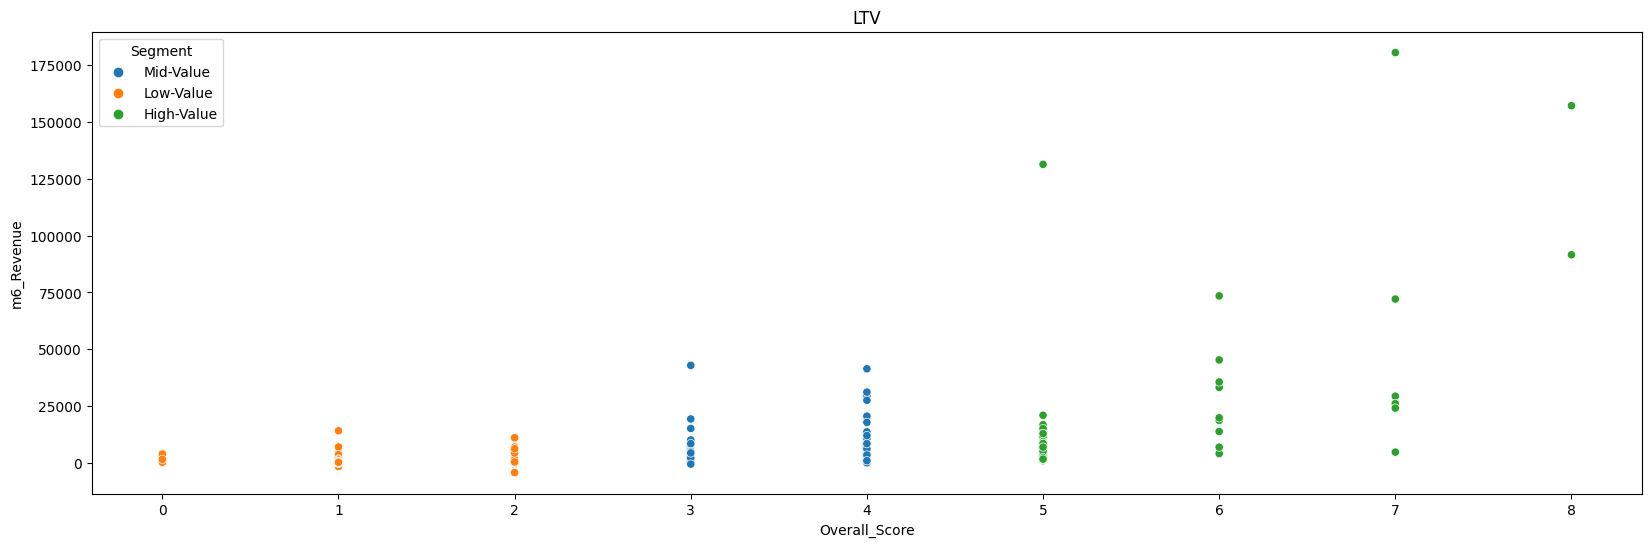

In [32]:
# plotting a graphy of m6_revenue vs overall_score
plt.figure(figsize=(20,6))
sns.scatterplot(data=cus_ctr,x='Overall_Score',y='m6_Revenue',hue='Segment')
plt.title('LTV');

In [33]:
# removing outliers
cus_ctr = cus_ctr[cus_ctr['m6_Revenue']<cus_ctr['m6_Revenue'].quantile(0.9)]

# creating three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(cus_ctr[['m6_Revenue']])
cus_ctr['LTVClusters'] = kmeans.predict(cus_ctr[['m6_Revenue']])

#order cluster number based on LTV
cus_ctr = order_cluster('LTVClusters','m6_Revenue',cus_ctr,True)

# making copy
cus_cluster = cus_ctr.copy()

In [34]:
cus_cluster.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster,Overall_Score,Segment,m6_Revenue,LTVClusters
0,13085.0,32,3,21,0,-695.72,-33.129524,0,3,Mid-Value,137.98,0
1,14748.0,20,3,181,0,2031.88,11.225856,0,3,Mid-Value,644.62,0
2,18037.0,32,3,24,0,111.82,4.659167,0,3,Mid-Value,9.20,0
3,16763.0,6,3,23,0,611.85,26.602174,0,3,Mid-Value,-16.95,0
4,17345.0,4,3,123,0,819.66,6.663902,0,3,Mid-Value,409.41,0


In [35]:
# decribing ltv cluster

cus_cluster.groupby('LTVClusters')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVClusters,,,,,,,,
0,1333.0,306.255965,224.989130,-4287.63,170.20,305.75,437.800,659.85
1,629.0,1014.688665,234.623608,663.49,809.10,986.05,1211.630,1503.99
2,339.0,1994.364041,367.687174,1509.21,1689.89,1921.09,2243.385,2876.02


2 is the best with average 1.3k LTV whereas 0 is the worst with 238.

In [36]:
# converting categorical data to numerical 

cus_cluster = pd.get_dummies(cus_cluster)
cus_cluster.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalRevenue,MeanRevenue,TotalRevenueCluster,Overall_Score,m6_Revenue,LTVClusters,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,13085.0,32,3,21,0,-695.72,-33.129524,0,3,137.98,0,0,0,1
1,14748.0,20,3,181,0,2031.88,11.225856,0,3,644.62,0,0,0,1
2,18037.0,32,3,24,0,111.82,4.659167,0,3,9.20,0,0,0,1
3,16763.0,6,3,23,0,611.85,26.602174,0,3,-16.95,0,0,0,1
4,17345.0,4,3,123,0,819.66,6.663902,0,3,409.41,0,0,0,1


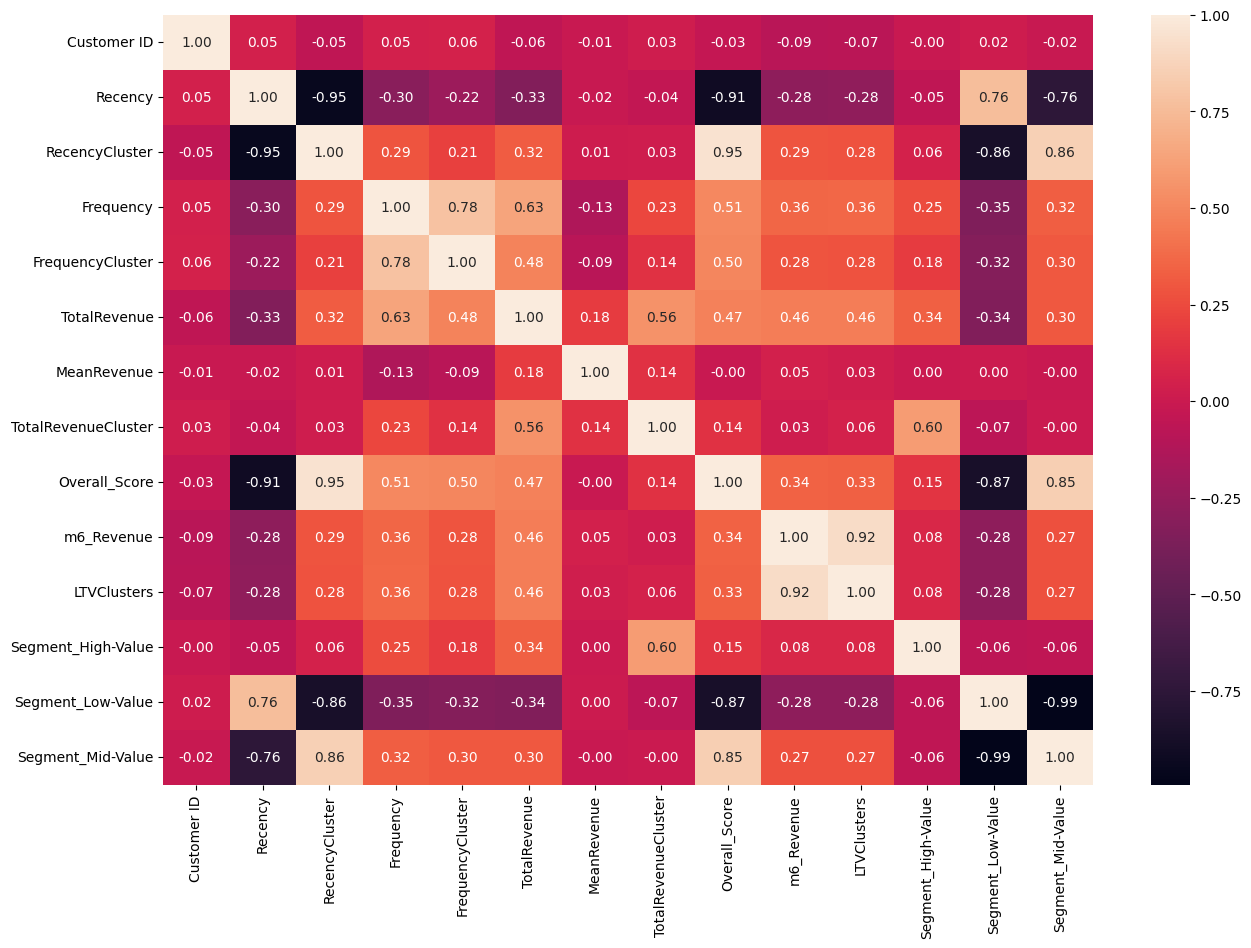

In [37]:
# cheching the correlation between features and our ltv label

corr = cus_cluster.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,annot=True,fmt='.2F');

## model Building

In [38]:
models = {
    'LogisticRegression' : LogisticRegression(),
    'RandomForestClalssifier' : RandomForestClassifier(),
    'XGb.xgb' : xgb.XGBClassifier(),
    'kneighbors' : KNeighborsClassifier(),
    'gradientboost' : GradientBoostingClassifier(),
    'Decisiontree' : DecisionTreeClassifier()
}

class_scorer = ['accuracy']

In [39]:
# function to perform cross validation on all metrics and display them for each model
def fit_and_score(model,x,y,scorer):
        metric =[]
        index = []
        kfold = KFold(n_splits=2, random_state=24, shuffle=True)
        for key,value in model.items() :
            index.append(key)
            for i in range(len(scorer)) :
                score = cross_val_score(value,x,y,scoring = scorer[i],cv = kfold)
                score = np.mean(score)
                metric.append(score)
        df = pd.DataFrame(np.array(metric).reshape(len(model),len(scorer)))
        df.columns = scorer
        df.index = index
        return df 

In [40]:
# splitting into x & y
x = cus_cluster.drop(['LTVClusters','m6_Revenue'],axis=1)
y = cus_cluster['LTVClusters']

<AxesSubplot: xlabel='LTVClusters', ylabel='count'>

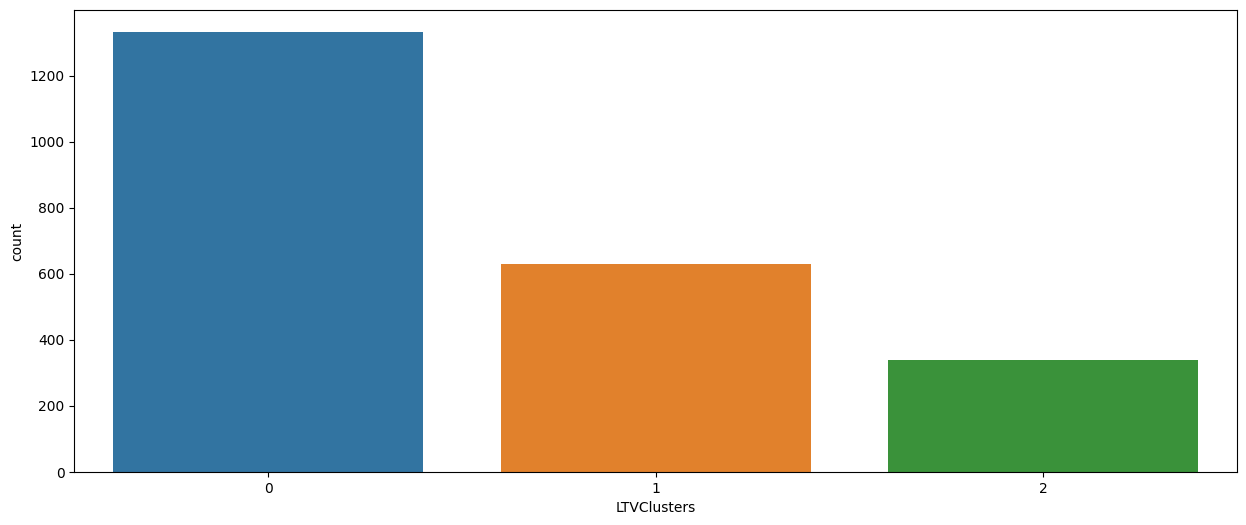

In [41]:
plt.figure(figsize=(15,6))
sns.countplot(data=cus_cluster,x=cus_cluster['LTVClusters'])

In [42]:
#balancing imbalance data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='not majority')
x_over,y_over = ros.fit_resample(x,y)

In [43]:
y_over.value_counts()

0    1333
1    1333
2    1333
Name: LTVClusters, dtype: int64

In [44]:
fit_and_score(models,x_over,y_over,class_scorer)

C:\Users\user\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

,accuracy
LogisticRegression,0.552893
RandomForestClalssifier,0.783946
XGb.xgb,0.779696
kneighbors,0.588649
gradientboost,0.661166
Decisiontree,0.735933


`xgboost` performs better than other models but it just over 70% acccuracy, so alot of improvement can be made to try to increase them

In [45]:
# splitting into training and test data

x_train,x_test,y_train,y_test = train_test_split(x_over,y_over,test_size=0.05,random_state=56)

### Hyperparameter tuning with `GridSearchCV`

In [49]:
kfold = KFold(n_splits=5, random_state=24, shuffle=True)
xgb_grid = {
    'max_depth' : [1,2,3,4,5,6,7,8,9,10],
    'learning_rate' : [0.01,0.1,0.4],
    'objective' : ['multi:softprob']
}

xgb_gs = GridSearchCV(xgb.XGBClassifier(),param_grid=xgb_grid,
                    scoring='accuracy',cv=kfold,verbose=1)

xgb_gs.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.4],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [50]:
xgb_gs.best_score_

0.8418015394216767

In [51]:
xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'objective': 'multi:softprob'}

### cross validation

In [54]:
print(f'cross_val_score {np.mean(cross_val_score(xgb_gs,x_over,y_over,cv=kfold,verbose=2))}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .................................................... total time= 1.7min
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END .................................................... total time= 1.6min
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .................................................... total time= 1.6min
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .................................................... total time= 1.5min
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .................................................... total time= 1.7min
cross_val_score 0.8569649561952442


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.1min finished


#### Classification report

In [55]:
y_preds = xgb_gs.predict(x_test)

print(classification_report(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81        57
           1       0.89      0.82      0.85        71
           2       1.00      0.92      0.96        72

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.89      0.88      0.88       200



In [56]:
## Savving model
from joblib import dump
dump(xgb_gs, 'Customer_lifetime_value_model.joblib')

['Customer_lifetime_value_model.joblib']